# Team 31 - Cheetah - Exaucee Manishimwe and Aleksandr Tikhonov

## The Erdős Institute - Data Science 2021 - Final Project

__Project Goal:__ Build a classification model which can detect schizophrenia based on electroencephalograph (EEG) data from a simple sensory task.

Data 0btained from https://www.kaggle.com/broach/button-tone-sz?select=ERPdata.csv. 

__Original Study:__

Ford, Judith M., Vanessa A. Palzes, Brian J. Roach, and Daniel H. Mathalon. "Did I do that? Abnormal predictive processes in schizophrenia when button pressing to deliver a tone." Schizophrenia bulletin 40, no. 4 (2014): 804-812.

Data Description: EEG data collected from 32 controls and 49 patients with schizophrenia who performed a simple button pressing task. All participants completed 100 trials of three conditions. Condition 1 involved pressing a button every 2-3 seconds which would immediately generate a brief tone. In condition 2, participants listened to the same tone in the time sequence generated in condition 1. In condition 3, participants pressed a button with no accompanying tone. The goal of the original study (among others) was to see if the difference in EEG activity between condition 1 (subtracting condition 3) and condition 2 would be different in control participants and participants with schizophrenia. It was hypothesized that participants with schizophrenia would have a harder time differentiating between a self (condition 1) and non-self (condition 2) generated audio signals relative to healthy controls. This difficulty would manifest in different EEG data patterns. The original study largely confirmed this hypothesis (see study cited above for details). 

__Current Project:__ 

Our group wanted to see if the data used in the original study by Ford et al. could be used for predictive instead of explanatory purposes. More specifically, we wanted to see if a classification model could be created which would effectively discriminate between those with and without schizophrenia using EEG data collected from the sensory task used by Ford et al. For the current analysis, trail event-related potential (ERP) averages for 9 electrode sites:

1. Fz: Front
2. FCz: Front-Central
3. Cz: Central 
4. FC3: Front-Central 3 
5. FC4: Front-Central 4
6. C3: Central 3
7. C4: Central 4
8. CP3: Central-parietal 3
9. CP4: Central-parietal 4

and 4 time periods 

1. B0: ~600 milisceoncs prior to stimulis onset 
2. B1: ~100 milisceoncs prior to stimulis onset 
3. N100: ~100 Seconds after stimulus onset
4. P200: ~200 Seconds after stimulus onset

were used. These data were provided by the authors of the original report (files: mergedTrialData.csv, demographics.csv) and underwent preprocessing as described here: https://www.kaggle.com/broach/button-tone-sz?select=ERPdata.csv. 

We did not use any particular condition data and instead averaged data from each electrode/time period for all of trials/conditions for each participant. Our rational for this decision being that EEG data is nosy and averaging all trials/conditions for each participant allowed us to get more information for each participant. We compared three types of algorithms (K nearest neighbors, Random Forest, and Logistic Regression) to see which one was the most effective. The results of our analysis are reported below. 

# Formatting Data

In [3]:
# Importing data processing and plotting packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

In [4]:
# Importing analysis packages and performance measures  

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# Loading data
# Available at https://www.kaggle.com/broach/button-tone-sz?select=ERPdata.csv.

mergedTrialData_df = pd.read_csv("mergedTrialData.csv")
demographics_df = pd.read_csv("demographic.csv")

In [7]:
# Averaging EEG data by subject
all_data_averaged_df = mergedTrialData_df.groupby('subject').mean()
# Merging EEG data with individual subject demographic data to obtain Schizophrenia status
all_data_averaged_df = all_data_averaged_df.merge(demographics_df, on='subject').rename(columns={' group': 'group'})
all_data_averaged_df.head()

,subject,trial,condition,ITI,rejected,Fz_N100,FCz_N100,Cz_N100,FC3_N100,FC4_N100,...,FC3_B1,FC4_B1,C3_B1,C4_B1,CP3_B1,CP4_B1,group,gender,age,education
0,1,50.171141,2.000000,2825.814358,0.030201,-3.758078,-3.709469,-3.430479,-3.159399,-3.759882,...,1.770834,0.828906,1.753613,0.670578,1.435104,0.932307,0,M,44,16.0
1,2,50.171141,2.000000,2350.668702,0.000000,-2.477591,-2.633028,-2.263567,-1.902506,-1.888696,...,0.285030,0.688827,0.346570,-0.044879,-0.074469,0.165761,0,M,39,17.0
2,3,50.171141,2.000000,1794.028080,0.036913,-3.714925,-4.351427,-4.252977,-2.789237,-2.799512,...,0.661526,1.149944,-0.206321,-0.355422,-1.118638,-0.935494,0,M,53,18.0
3,4,50.003367,2.003367,2227.263372,0.030303,-4.717606,-4.224721,-3.074499,-2.741106,-3.452926,...,2.255097,1.417232,2.326886,1.577574,2.142686,1.302185,0,M,52,15.0
4,5,50.334448,2.000000,2515.888944,0.030100,-3.637179,-3.890643,-3.407677,-3.308248,-3.304539,...,2.975226,2.480377,2.418446,2.309906,1.685082,1.826066,0,M,41,16.0


In [8]:
# Removing features which will not be used in any analysis
all_EEG_data_averaged = all_data_averaged_df.drop(columns=['subject','trial','condition',
                                                            'ITI','rejected',' gender',' age',' education'])

# Converting data to array for ease of use
all_EEG_data_averaged = all_EEG_data_averaged.to_numpy()

#Splitting data into predictive features (X - EGG data) 
#and target variable (y - 0 - control, 1 - Schizophrenia)

X = all_EEG_data_averaged[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,
                       33,34,35]]

y = all_EEG_data_averaged[:,[36]]

In [9]:
# Splitting data into a training and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 614, 
                                                    shuffle=True,
                                                    stratify=y)

# K nearest neighbors model

Performing Cross-Validation to locate optimal K parameter

In [11]:
kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state=614)

# Run CV for a maximum of K = 25
max_neighbors = 25

#Arrays to store accuracy, percision, and recall for each iteration
accs = np.zeros((5,max_neighbors))
precs = np.zeros((5,max_neighbors))
recs = np.zeros((5,max_neighbors))

## keep track of the train test split
j = 0

# Sub-splitting training data 
for train_index, test_index in kfold.split(X_train,y_train):
    # Get the cv train test split
    X_train_train, X_train_test = X_train[train_index], X_train[test_index]
    y_train_train, y_train_test = y_train[train_index], y_train[test_index]
    for i in range(1,max_neighbors+1):
        knn = KNeighborsClassifier(i)
        
        # fit the model
        knn.fit(X_train_train, y_train_train.ravel())
        
        # calculate prediction based on model
        y_predict = knn.predict(X_train_test)
        
        #calculate and store performance measures
        accs[j,i-1] = accuracy_score(y_train_test,y_predict)
        precs[j,i-1] = precision_score(y_train_test,y_predict)
        recs[j,i-1] = recall_score(y_train_test,y_predict)
        
    j=j+1

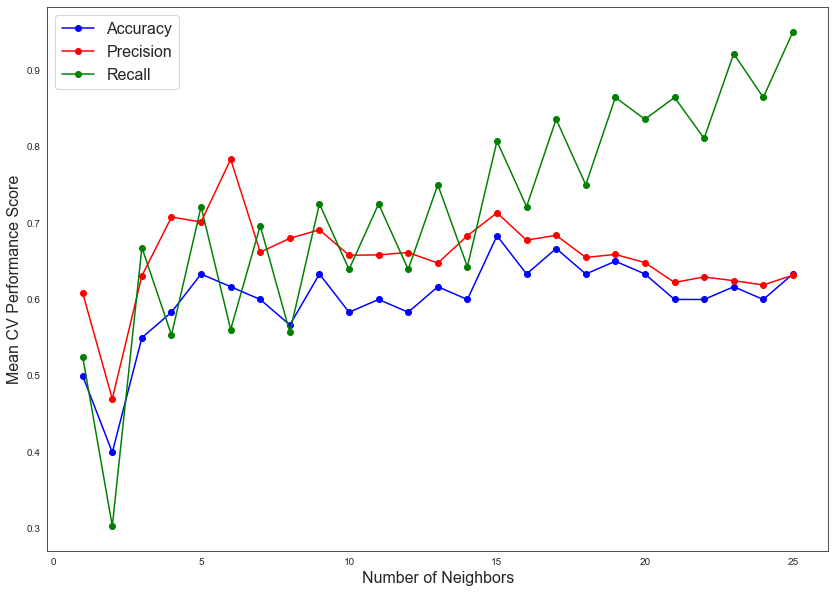

In [12]:
# Graph CV results

plt.figure(figsize=(14,10))

plt.plot(range(1,max_neighbors+1), np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(1,max_neighbors+1), np.mean(precs,axis=0),'r-o', label="Precision")
plt.plot(range(1,max_neighbors+1), np.mean(recs,axis=0),'g-o', label="Recall")

plt.ylabel("Mean CV Performance Score",fontsize=16)
plt.xlabel("Number of Neighbors", fontsize=16)

plt.legend(fontsize=16)

plt.show()

K = 15 appears to produce best overall results.
Fitting best model below.

In [13]:
#Creating model object
all_averaged_knn_15 = KNeighborsClassifier(15)
#Fitting model
all_averaged_knn_15.fit(X_train, y_train.ravel())

KNeighborsClassifier(n_neighbors=15)

In [19]:
#Examining overall train set performance measures
y_predict = all_averaged_knn_15.predict(X_train)
print("KNN model training performance:")
print()
print("accuracy:", 100*np.round(accuracy_score(y_train,y_predict),4),'%')
print()
print('precision:', 100*np.round(precision_score(y_train,y_predict),4),'%')
print()
print('recall:', 100*np.round(recall_score(y_train,y_predict),4),'%')

KNN model training performance:

accuracy: 65.0 %

precision: 65.96 %

recall: 86.11 %


<AxesSubplot:>

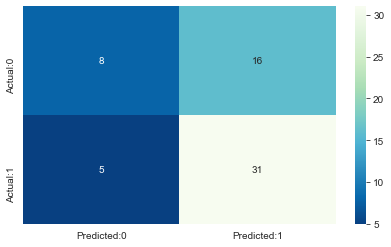

In [22]:
# Creating confusion matrix for training data
cm=confusion_matrix(y_train,y_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (7,4))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="GnBu_r")

In [24]:
#Examining overall test set performance measures
y_predict = all_averaged_knn_15.predict(X_test)
print("KNN model test performance:")
print()
print("accuracy:", 100*np.round(accuracy_score(y_test,y_predict),4),'%')
print()
print('precision:', 100*np.round(precision_score(y_test,y_predict),4),'%')
print()
print('recall:', 100*np.round(recall_score(y_test,y_predict),4),'%')

KNN model test performance:

accuracy: 71.43 %

precision: 73.33 %

recall: 84.61999999999999 %


<AxesSubplot:>

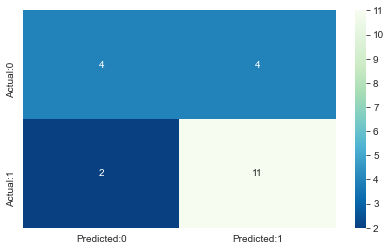

In [25]:
# Creating confusion matrix for test data
cm=confusion_matrix(y_test,y_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (7,4))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="GnBu_r")

__Findings:__ Overall, the KNN model performed above chance on both the training and test data. On the test data, the model correctly identified 11 out 13 Schizophrenia subjects but only 4 out 8 healthy controls.

# Random Forest Model

Performing Cross-Validation to locate optimal max-depth parameter

In [26]:
kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state=614)

# n will be the maximum max_depth considered
n = 25

#Arrays to store accuracy, percision, and recall for each iteration
accs = np.zeros((5,n))
precs = np.zeros((5,n))
recs = np.zeros((5,n))

#Loop for max_depth
for j in range(1,n+1):
    #fitting model
    rf = RandomForestClassifier(n_estimators = 500,max_depth=j, random_state = 614)
    
    # Sub-splitting training data 
    i = 0
    for train_index,test_index in kfold.split(X_train,y_train):
        X_train_train, X_train_test = X_train[train_index],X_train[test_index]
        y_train_train, y_train_test = y_train[train_index],y_train[test_index]

        #Clone model
        rf_clone = clone(rf)
        rf_clone.fit(X_train_train,y_train_train.ravel())
        
        #calculate prediction based on model
        y_predict = rf_clone.predict(X_train_test)
        
        #calculate and store performance measures
        accs[i,j-1] = accuracy_score(y_train_test,y_predict)
        precs[i,j-1] = precision_score(y_train_test,y_predict)
        recs[i,j-1] = recall_score(y_train_test,y_predict)
        i = i + 1

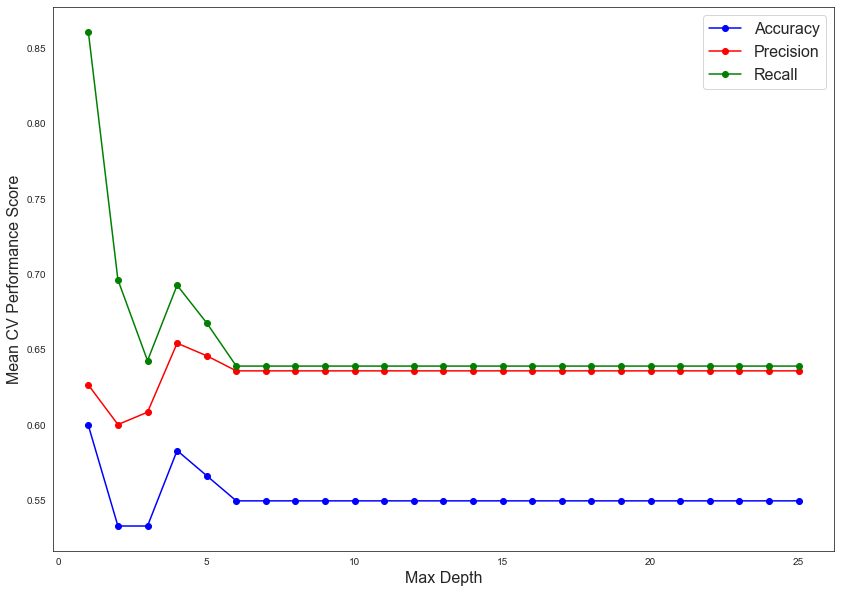

In [27]:
# Graph CV results
plt.figure(figsize=(14,10))

plt.plot(range(1,n+1), np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(1,n+1), np.mean(precs,axis=0),'r-o', label="Precision")
plt.plot(range(1,n+1), np.mean(recs,axis=0),'g-o', label="Recall")

plt.ylabel("Mean CV Performance Score",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)

plt.legend(fontsize=16)

plt.show()

Max_depth = 1 appears to produce best overall results.
Fitting best model below.

In [28]:
#Creating Model object with max_depth = 1
all_averaged_rf_1 = RandomForestClassifier(n_estimators = 500,max_depth=1, random_state = 614)
#Fitting model
all_averaged_rf_1.fit(X_train,y_train.ravel())

RandomForestClassifier(max_depth=1, n_estimators=500, random_state=614)

In [34]:
#Examining overall train set performance measures
y_predict = all_averaged_rf_1.predict(X_train)
print("Random forest model training performance:")
print()
print("accuracy:", 100*np.round(accuracy_score(y_train,y_predict),4),'%')
print()
print('precision:', 100*np.round(precision_score(y_train,y_predict),4),'%')
print()
print('recall:', 100*np.round(recall_score(y_train,y_predict),4),'%')

Random forest model training performance:

accuracy: 76.67 %

precision: 72.92 %

recall: 97.22 %


<AxesSubplot:>

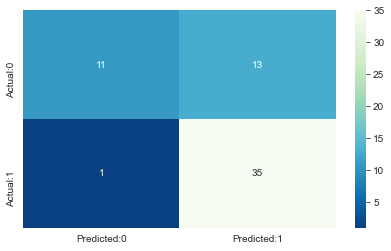

In [35]:
# Creating confusion matrix for training data
cm=confusion_matrix(y_train,y_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (7,4))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="GnBu_r")

In [38]:
#Examining overall test set performance measures
y_predict = all_averaged_rf_1.predict(X_test)
print("Random forest model test performance:")
print()
print("accuracy:", 100*np.round(accuracy_score(y_test,y_predict),4),'%')
print()
print('precision:', 100*np.round(precision_score(y_test,y_predict),4),'%')
print()
print('recall:', 100*np.round(recall_score(y_test,y_predict),4),'%')

Random forest model test performance:

accuracy: 76.19 %

precision: 75.0 %

recall: 92.31 %


<AxesSubplot:>

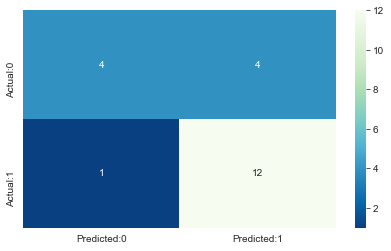

In [39]:
# Creating confusion matrix for test data
cm=confusion_matrix(y_test,y_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (7,4))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="GnBu_r")

__Findings:__ Overall, the Random Forest model performed above chance and slightly better on both the training and test data than the KNN model. On the test data, the model correctly identified 12 out 13 Schizophrenia subjects but also only 4 out 8 healthy controls.

# Logistic Regression Model

Cross-Validation not performed due to technical and skill based limitations

In [41]:
#Creating Model object
all_averaged_log_reg = LogisticRegression(random_state = 614)
#Fitting Model
all_averaged_log_reg.fit(X_train,y_train.ravel())

LogisticRegression(random_state=614)

In [46]:
#Examining overall train set performance measures
y_predict = all_averaged_log_reg.predict(X_train)
print("Logistic regression model training performance:")
print()
print("accuracy:", 100*np.round(accuracy_score(y_train,y_predict),4),'%')
print()
print('precision:', 100*np.round(precision_score(y_train,y_predict),4),'%')
print()
print('recall:', 100*np.round(recall_score(y_train,y_predict),4),'%')

Logistic regression model training performance:

accuracy: 75.0 %

precision: 75.61 %

recall: 86.11 %


<AxesSubplot:>

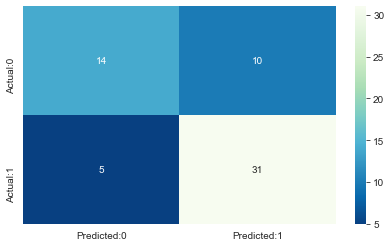

In [47]:
# Creating confusion matrix for training data
cm=confusion_matrix(y_train,y_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (7,4))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="GnBu_r")

In [48]:
#Examining overall test set performance measures
y_predict = all_averaged_log_reg.predict(X_test)
print("Logistic regression model test performance:")
print()
print("accuracy:", 100*np.round(accuracy_score(y_test,y_predict),4),'%')
print()
print('precision:', 100*np.round(precision_score(y_test,y_predict),4),'%')
print()
print('recall:', 100*np.round(recall_score(y_test,y_predict),4),'%')

Logistic regression model test performance:

accuracy: 80.95 %

precision: 80.0 %

recall: 92.31 %


<AxesSubplot:>

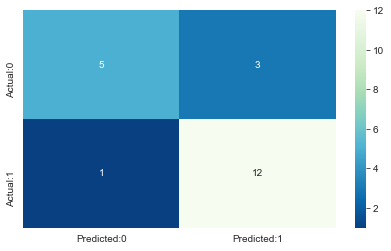

In [49]:
# Creating confusion matrix for test data
cm=confusion_matrix(y_test,y_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (7,4))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="GnBu_r")

__Findings:__ Overall, the Logistic Regression model performed above chance and better on both the training and test data than both the KNN and random forest models. On the test data, the model correctly identified 12 out 13 Schizophrenia subjects and 5 out 8 healthy controls. The model produced three false positives and only one false negative. 

__Conclusion__: The analysis shown here demonstrates the potential for EEG data being used as a diagnostic tool for schizophrenia. The data used here was collected while participants performed a simple button pressing task and we did not stratify this data based on any condition/trial but simply used the aggregated EEG activity from each participant in our models. Despite this relatively simplistic approach, our best classification model was able to produce 80% test data accuracy when differentiating between EEG data collected from those with and without schizophrenia. With further refinement, such models have some potential to be employed in therapeutic settings. This diagnostic approach may be used as a more objective supplement in clinical diagnoses which currently frequently rely on clinical judgment based on patient self-report.  